In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

22

# set_seed(42)

In [2]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [3]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [4]:
import os
os.listdir()

['logs',
 '電文資料',
 'preprocess_for_SQUAD_開狀人.csv',
 'Product_Data_summarize(undone).ipynb',
 'Product_Data_SQuAD_wordninja.ipynb',
 'combined_excel (3).xlsx',
 '切開狀人.ipynb',
 'preprocess_for_SQUAD.csv',
 'Product_Data_SQuAD-開狀人.ipynb',
 'Train_Product_Data_2021_0114.csv',
 'Product_Data_SQuAD_knowledge distillation V2.ipynb',
 '全部集合.txt.gz',
 'ERP資料',
 'Product_Data_SQuAD_product.ipynb',
 'Product_Data_ner.ipynb',
 'submit.csv',
 'Collection method-plus-bert.ipynb',
 'Product_Data_SQuAD_model_V2.pt',
 'EDA.ipynb',
 '台塑企業_ 產品寶典20210303.xlsx',
 'preprocess_for_SQUAD_product.csv',
 'Product_Data_SQuAD_model_2144.pt',
 'aclImdb',
 'preprocess_for_SQUAD_wordninja.csv',
 'load_model_and_test-V2.ipynb',
 '產品集合.txt',
 'load_model_and_test.ipynb',
 '切開狀人.csv',
 'preprocess_for_SQUAD_product.ipynb',
 'input',
 'aclImdb_v1.tar.gz',
 'Collection method.ipynb',
 'Product_Data_SQuAD_knowledge distillation.ipynb',
 'load_model_and_test-抽中間特徵.ipynb',
 'Val_Product_Data_2021_0114.csv',
 'submit_0726.cs

In [5]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('preprocess_for_SQUAD_product.csv',index_col=0)[['45A','Y_label','string_Y_1','string_Y_2']].dropna(axis=0)
df.iloc[:,-2:] = df.iloc[:,-2:].astype(int)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df = df.rename(columns={'45A':'string_X_train'})
print(df.shape)
train_df, val_df = train_test_split(df,test_size=0.1,random_state=42)
display(train_df.head(100))
display(val_df.head(100))

(3088, 4)


,string_X_train,Y_label,string_Y_1,string_Y_2
2527,COUNTRY OF ORIGIN TAIWAN x 000 D PRICE TERMS C...,VISCOSE STAPLE FIBER,76,96
2157,1 COMMODITY HDPE TAISOX 9001 x 000 D QUANTITY ...,HDPE TAISOX,12,23
1213,COMMODITY QUANTITY UNIT PRICE AMOUNT x 000 DEV...,EVA TAISOX,44,54
1767,1 48000 KGS POLYPROPYLENE HOMOPOLYMER RESIN GR...,POLYPROPYLENE COPOLYMER RESIN,81,110
1565,TAIRILAC ABS RESINS x 000 D GRADE NOA G 15 AB ...,ABS RESIN,9,18
...,...,...,...,...
2955,COMMODITY POLYPROPYLENE RANDOM COPOLYMER RESIN...,POLYPROPYLENE,10,23
2725,COVERING 100 PERCENT OF INVOICE VALUE OF GOODS...,COVERING,0,8
1506,POLYPROPYLENE 1250 Dx 000 D QUANTITY 160 MT x ...,POLYPROPYLENE,0,13
568,POM FORMOCON FM 090 54000 KG NET x 000 D UNIT ...,PACK,94,98


,string_X_train,Y_label,string_Y_1,string_Y_2
3024,EVA TAISOX 7240 M CI F PORT KLANG MALAYSIA,EVA TAISOX,0,10
1805,GLASS EPOXY COPPER CLAD LAMINATE SHEET AS PER ...,COPPER CLAD LAMINATE,12,32
2698,3200 MT OF HIPS RESIN GRADE NO HP9450 x 000 DA...,HIPS RESIN,11,21
2551,PLASTIC RESIN C IP SHENZHEN CHINA x 000 D 1 1 ...,PLASTIC RESIN,0,13
2490,3000 KGS OF PROCESSING AID P - 201 x 000 D 300...,PE,135,137
...,...,...,...,...
1536,TERMS OF PRICE CFR CAL LAO PER Ux 000 D COUNTR...,MALEIC ANHYDRIDE,73,89
485,36 METRIC TON PVC SUSPENSION RESIN S65D IN 25 ...,PVC SUSPENSION RESIN,14,34
3066,METHYL TETRA HYDRO PHTHALIC ANHYDRIDE x 000 D ...,EVA,171,174
1080,CFR KARACHI SEAPORT x 000 D QT Y 18 MT TAIRILA...,ABS RESIN,48,57


In [6]:
for i in tqdm(range(len(df))):
    assert df['Y_label'].values[i] in df['string_X_train'].values[i]

  0%|          | 0/3088 [00:00<?, ?it/s]

# Model and Tokenizer Initialization

In [7]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

248

# Data preprocessing

In [8]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [9]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [10]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

21

# data is ready put it in a PyTorch dataset

In [11]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

21

# train loop

In [12]:
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle=True ,num_workers=4)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [13]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch:0 train_loss:1.0780919282939392 val_loss:0.4188173272107777
save best_model now_val_best_loss is:0.4188173272107777


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch:1 train_loss:0.37891150571707355 val_loss:0.25646080253155606
save best_model now_val_best_loss is:0.25646080253155606


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch:2 train_loss:0.374751208080894 val_loss:0.28624807709926053
not_improve_count:1


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch:3 train_loss:0.28940104438002745 val_loss:0.26945539818782555
not_improve_count:2


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch:4 train_loss:0.20934303184551312 val_loss:0.1919914770283197
save best_model now_val_best_loss is:0.1919914770283197


# loss curve

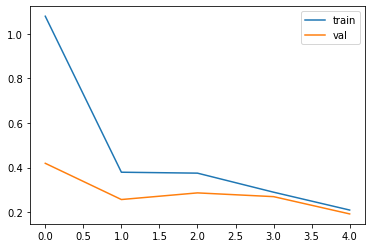

In [21]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [22]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

# test

In [23]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [52]:
all_res = test_model(val_df.sample(50))
all_res

  0%|          | 0/50 [00:00<?, ?it/s]

,label,predict:,是否全對
45,BASE OIL 500N,BASE OIL 500N,Yes
2204,HDPE,HDPE,Yes
1374,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
1264,ACRYLONITRILE BUTADIENE STYRENE,ACRYLONITRILE BUTADIENE STYRENE,Yes
139,PVC RESIN,PVC RESIN,Yes
1675,PE,PER,No
457,EVA-7360M,EVA-7360M,Yes
555,HDPE TAISOX,HDPE TAISOX,Yes
218,PVC SUSPENSION RESIN,PVC SUSPENSION RESIN,Yes
449,BASE OIL 150N,BASE OIL 150N,Yes


In [53]:
all_res[all_res['是否全對']=='No']

,label,predict:,是否全對
1675,PE,PER,No
2593,PURIFIED ISOPHTHALIC ACID PIA,ISOPHTHALIC ACID PIA,No
2229,ETHYLENE,MONOETHYLENE GLYCOL MEG,No
819,POLYPROPYLENE,POLYPROPYLENE RESIN K 1035 AND 12 MT OF PROPYLENE,No
2644,PP RESIN,DPP RESIN,No
2210,TAIRIREX POLYSTYRENE,TAIRIREX POLYSTYRENE GRADE GP5500,No
3066,EVA,METHYL TETRA HYDRO PHTHALIC ANHYDRIDE,No
1948,PVC RESIN,PVC RESIN S60,No
838,PVC RESIN,PVC RESIN S-65S,No
1937,ABS RESIN,ABS RESINS,No


# claculate acc and jaccard

In [54]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

display(all_res['是否全對'].value_counts())
acc = all_res['是否全對'].value_counts()['Yes']/len(all_res)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

Yes    39
No     11
Name: 是否全對, dtype: int64

acc: 0.78
jaccard_avg_score: 0.8538888888888888


# claculate 放水acc

In [55]:
def get_acc2(df):
    correct = []
    correct_label = []
    df['predict:'] = [[i] for i in df['predict:']]
    for i in df.index:
        jacs = []
        for j in df.loc[i,'predict:']:
            jacs.append(get_jaccard_sim(df.loc[i,'label'],j))
        if max(jacs) >= 0.75:
            correct.append('yes')
        else:
            correct.append('no')
    return correct

In [56]:
a = pd.Series(get_acc2(all_res.sample(50)))
a.value_counts()['yes']/len(a)

0.8

In [57]:
torch.save(model.state_dict(),'Product_Data_SQuAD_model_2144.pt')